# Image analysis for control charts for Power Bed Laser Fusion

## Data manipolation

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

file_path = "data/stacked_data.csv"
df = pd.read_csv(file_path)

df.head()

,t,x,y,z,layer_id,sensor0,sensor1,temp,track_id,track_orient,pos_rel,t_rel
0,127875690.0,38.119,-54.480,8.96,224,800.0,805.0,1580.9,0,271,0.00000,0.0
1,127875700.0,38.118,-54.489,8.96,224,807.0,801.0,1596.0,0,271,0.00721,10.0
2,127875710.0,38.119,-54.498,8.96,224,813.0,809.0,1593.2,0,271,0.01442,20.0
3,127875720.0,38.119,-54.508,8.96,224,813.0,824.0,1573.0,0,271,0.02163,30.0
4,127875730.0,38.121,-54.515,8.96,224,820.0,825.0,1581.0,0,271,0.02884,40.0


Generate a temperature matrix

In [3]:
# first create pivot table and then crop
def generate_temperature_matrices_v1(df, layer_ids, x_range, y_range, digits_round=1):
    temperature_matrices = []
    for layer_id in layer_ids:
        layer_df = df[df['layer_id'] == layer_id]

        #layer_df['x_bin'] = layer_df['x'].round(digits_round)
        #layer_df['y_bin'] = layer_df['y'].round(digits_round)
        layer_df['x_bin'] = np.floor(layer_df['x'] * (10 ** digits_round)) / (10 ** digits_round)
        layer_df['y_bin'] = np.floor(layer_df['y'] * (10 ** digits_round)) / (10 ** digits_round)

        # Create a pivot table with the grouped x and y values with mean
        temperature_matrix = layer_df.pivot_table(index='y_bin', columns='x_bin', values='temp', aggfunc='median')
        
        # Fill missing values with interpolation or a default value
        temperature_matrix = temperature_matrix.interpolate(axis=0).interpolate(axis=1)
        
        # Crop the temperature matrix based on the x_range and y_range
        cropped_matrix = temperature_matrix.loc[y_range[0]:y_range[1], x_range[0]:x_range[1]]
        temperature_matrices.append(cropped_matrix.to_numpy())
    return np.array(temperature_matrices)

In [5]:
digits_round = 1
x_range = (26.292, 38.089)
y_range = (-66.633, -54.62)
layer_ids = [224, 225, 226, 227, 228, 324, 325, 326, 327, 328, 424, 425, 426, 427, 428, 524, 525, 526, 527, 528, 569, 570, 571, 572, 573]
list_25l = generate_temperature_matrices_v1(df, layer_ids, x_range, y_range, digits_round)

C:\Users\Utente\AppData\Local\Temp\ipykernel_12852\437303520.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df['x_bin'] = np.floor(layer_df['x'] * (10 ** digits_round)) / (10 ** digits_round)
C:\Users\Utente\AppData\Local\Temp\ipykernel_12852\437303520.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df['y_bin'] = np.floor(layer_df['y'] * (10 ** digits_round)) / (10 ** digits_round)


Collect T² statistics across batches

max(T²) How extreme the hottest point is.

In [12]:
import numpy as np
from sklearn.decomposition import PCA
from scipy.stats import f
import matplotlib.pyplot as plt

def analyze_temperature_matrices(list_25l, confidence=0.95, plot=True):
    """
    Applies PCA and computes Hotelling's T² statistics for a list of temperature matrices.
    
    Args:
        list_25l (list): List of 2D numpy arrays (samples x features).
        confidence (float): Confidence level for anomaly threshold (e.g., 0.95).
        plot (bool): Whether to plot T² statistics and thresholds.
        
    Returns:
        dict: {
            "t2_values": list of arrays of T² statistics,
            "thresholds": list of float thresholds,
            "anomalies": list of index arrays for detected anomalies
        }
    """
    t2_values = []
    thresholds = []
    anomalies = []

    for i, matrix in enumerate(list_25l):
        pca = PCA(n_components=0.90)
        scores = pca.fit_transform(matrix)
        std_devs = np.sqrt(pca.explained_variance_)
        t2 = np.sum((scores / std_devs) ** 2, axis=1)
        t2_values.append(t2)

        n_samples = matrix.shape[0]
        n_components = scores.shape[1]
        f_crit = f.ppf(confidence, n_components, n_samples - n_components)
        threshold = (n_components * (n_samples - 1) / (n_samples - n_components)) * f_crit
        thresholds.append(threshold)

        anomaly_indices = np.where(t2 > threshold)[0]
        anomalies.append(anomaly_indices)

        if plot:
            plt.figure(figsize=(10, 4))
            plt.plot(t2, marker='o', label='T²')
            plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
            plt.title(f'Hotelling T² - Matrix {i+1}')
            plt.xlabel('Sample Index')
            plt.ylabel('T² Value')
            plt.legend()
            plt.grid(True)
            plt.show()

    return {
        "t2_values": t2_values,
        "thresholds": thresholds,
        "anomalies": anomalies
    }


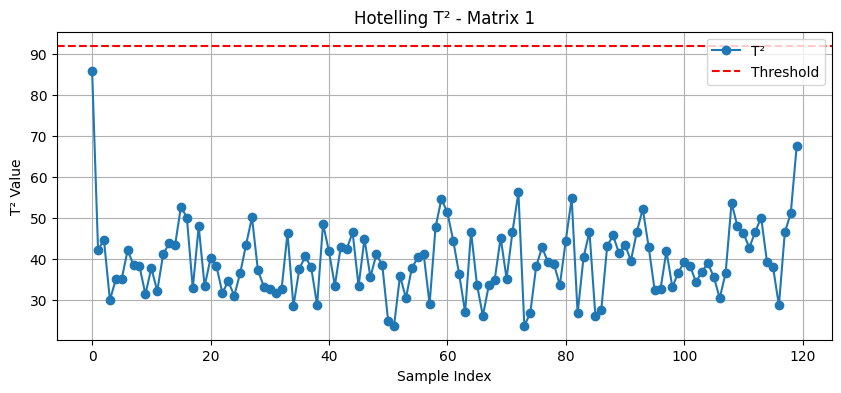

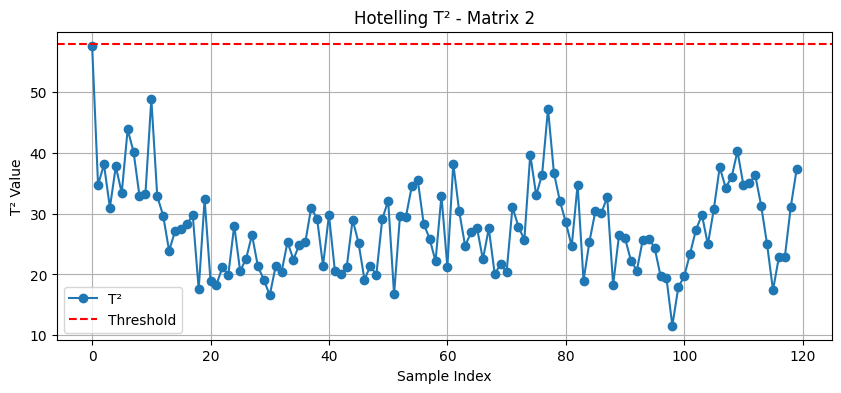

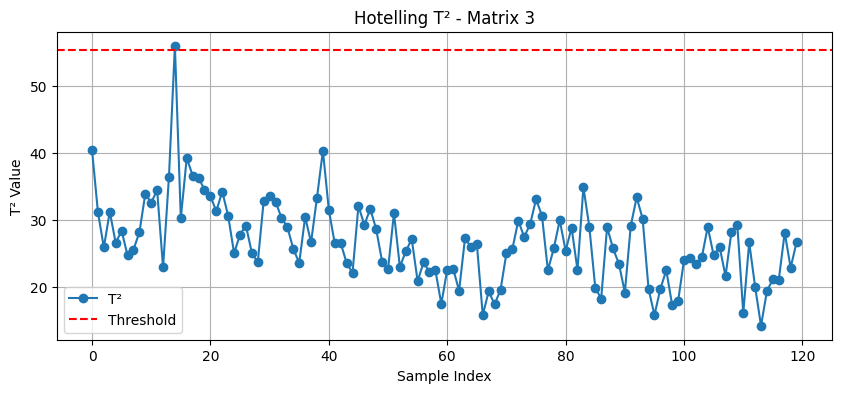

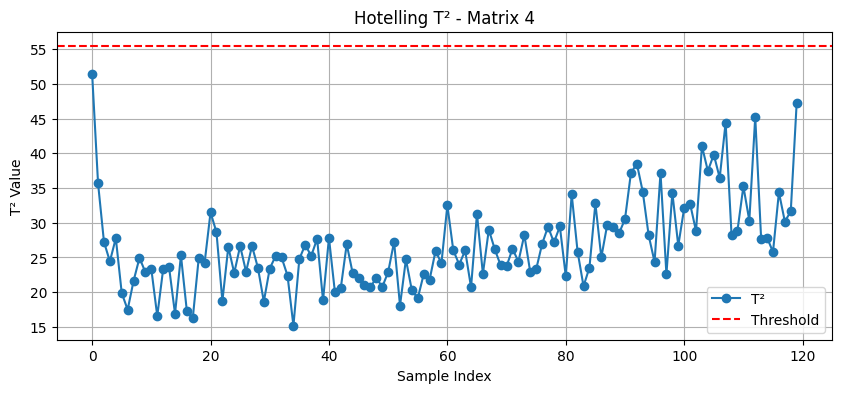

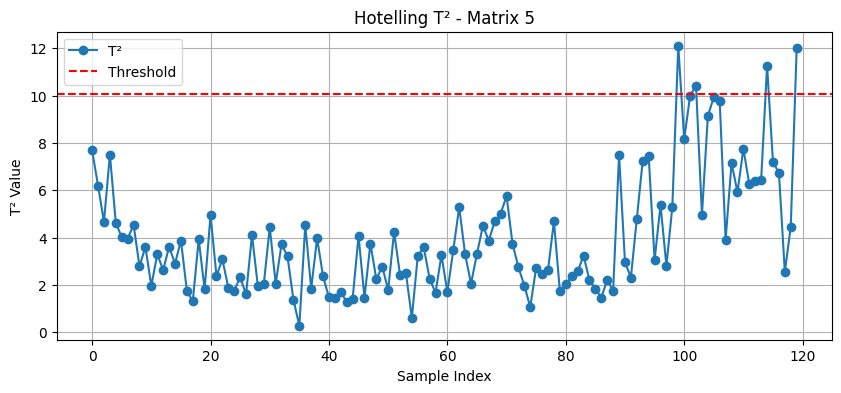

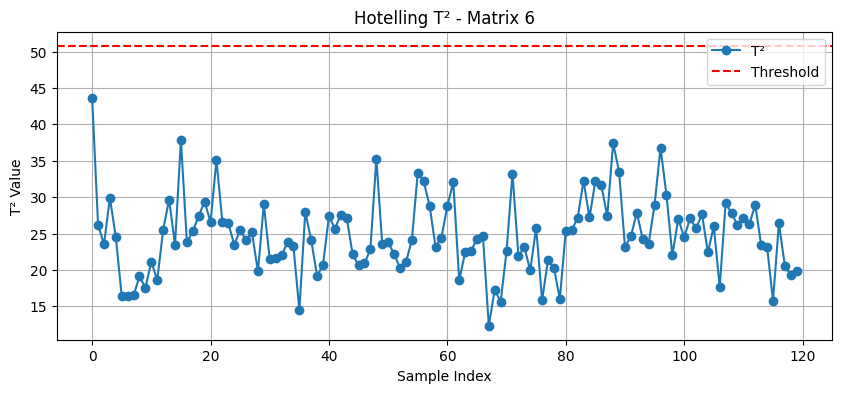

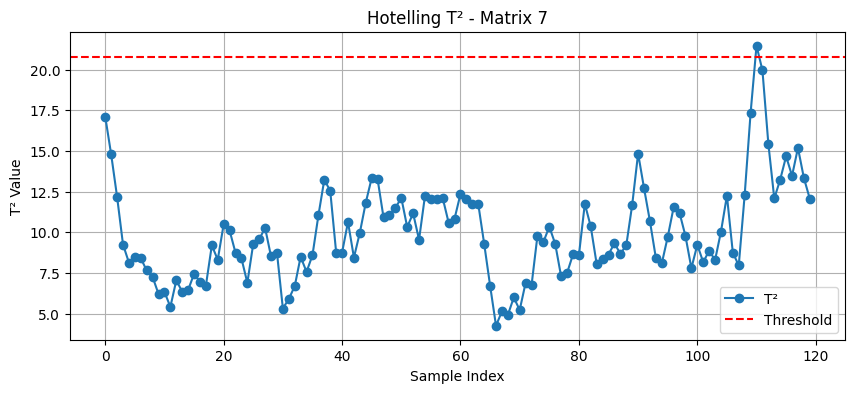

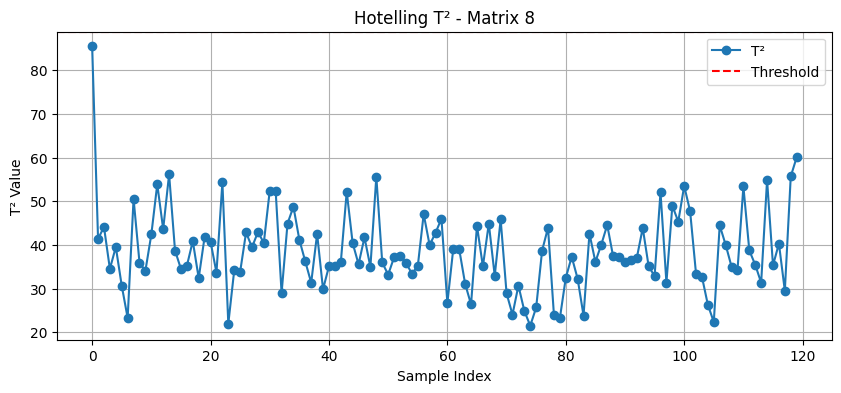

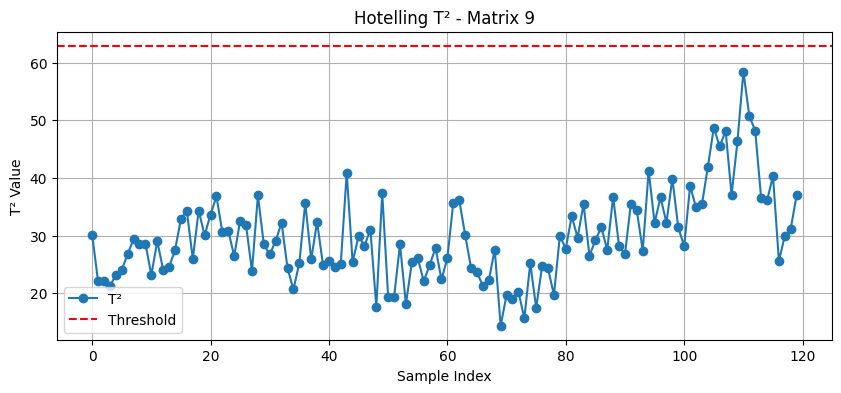

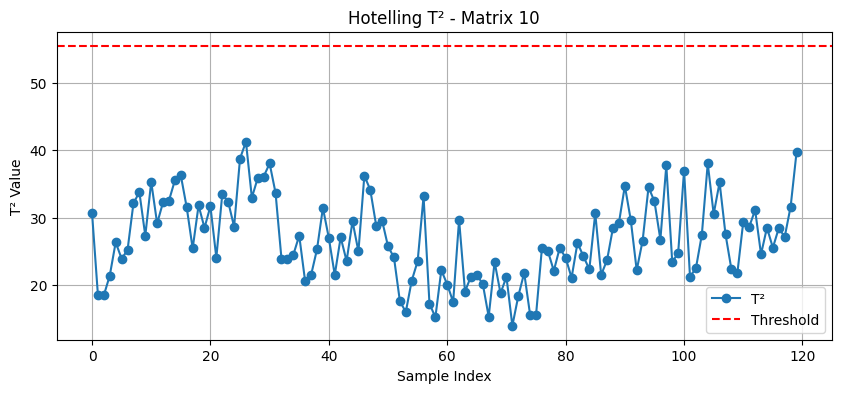

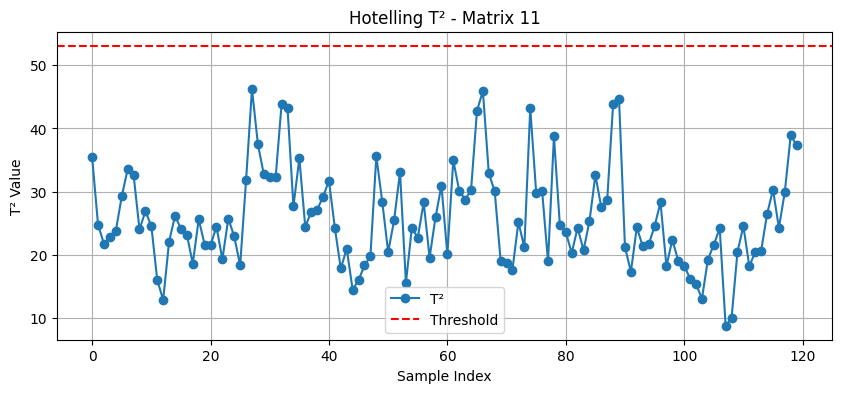

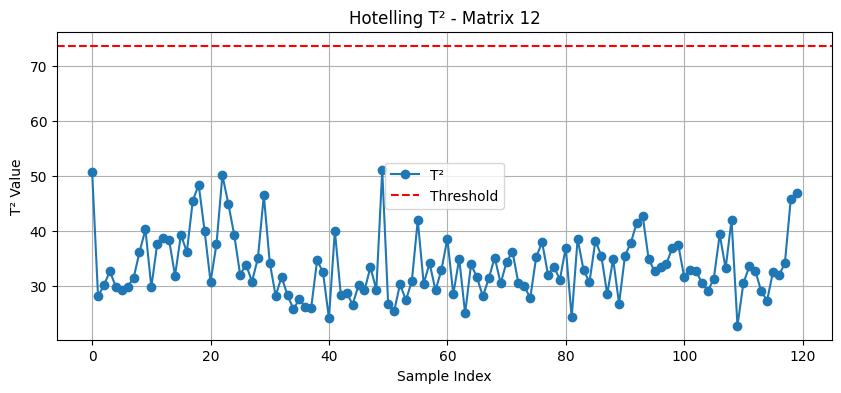

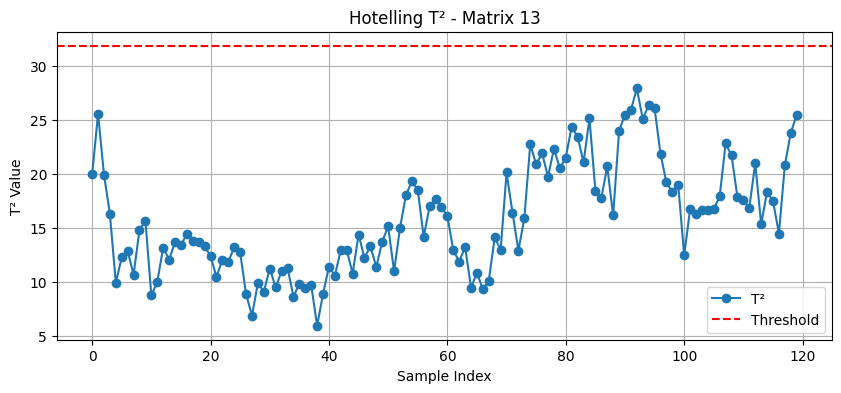

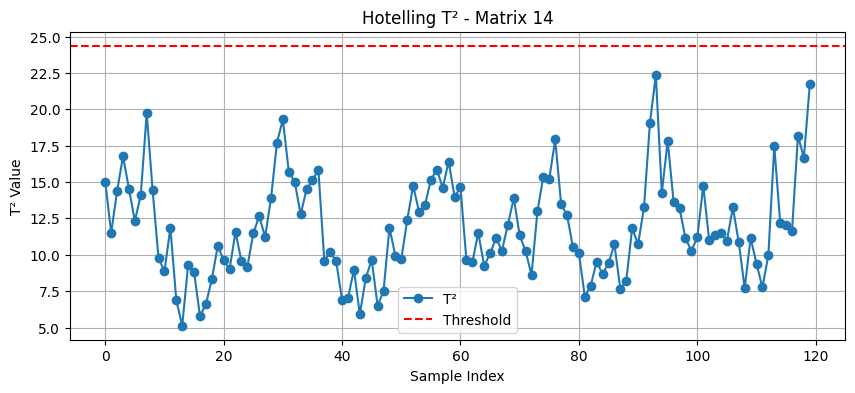

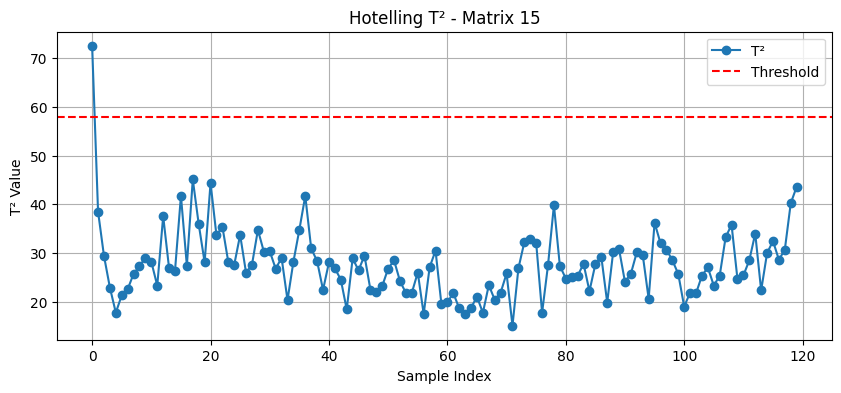

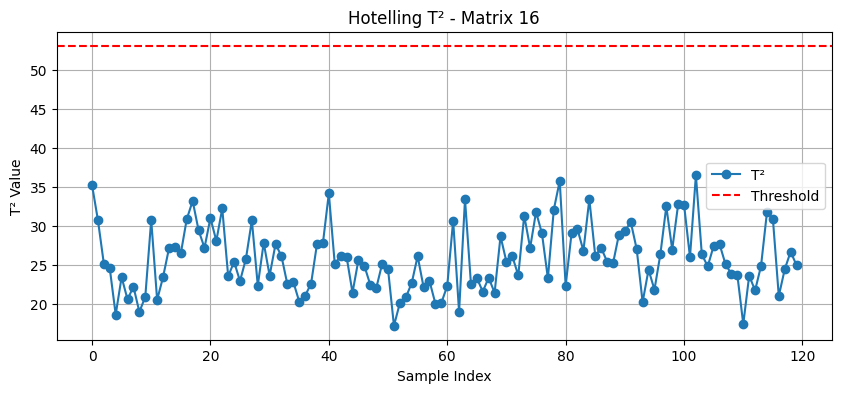

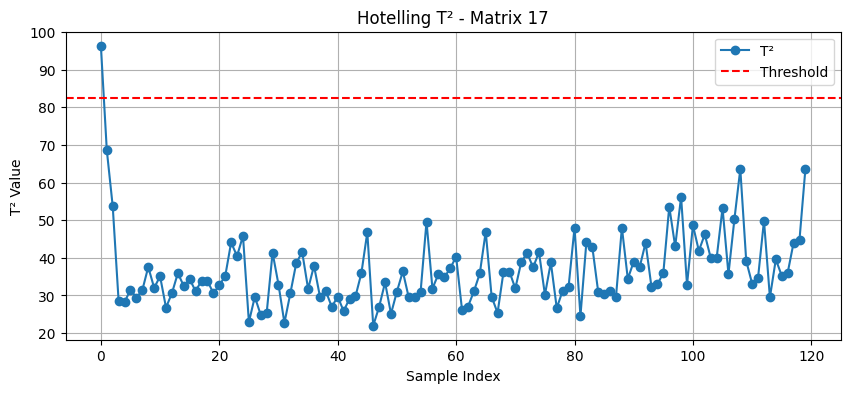

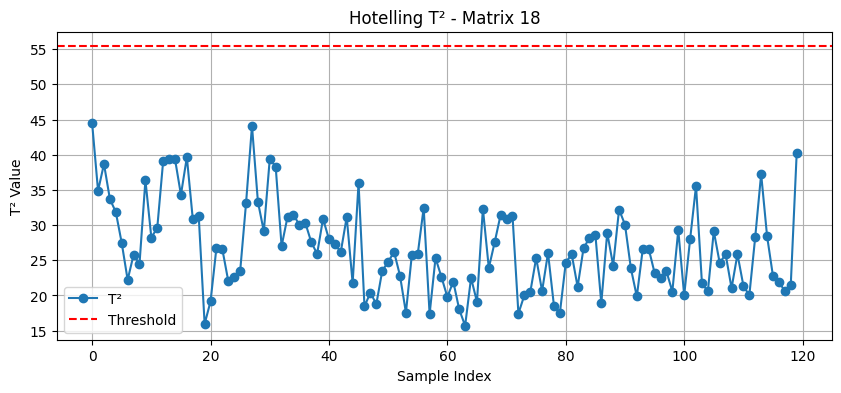

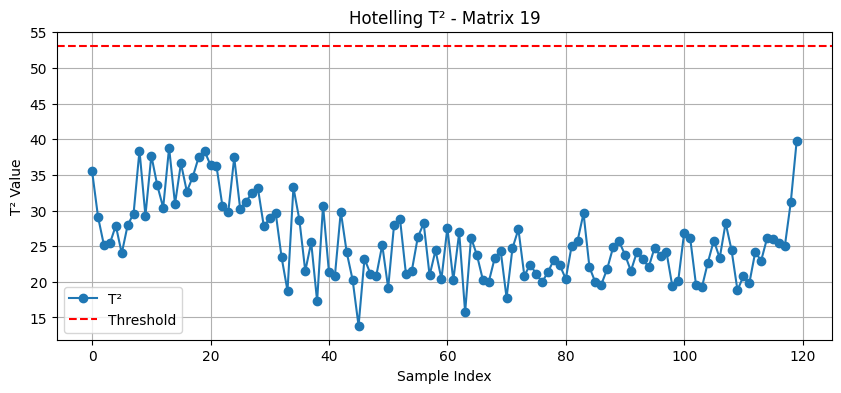

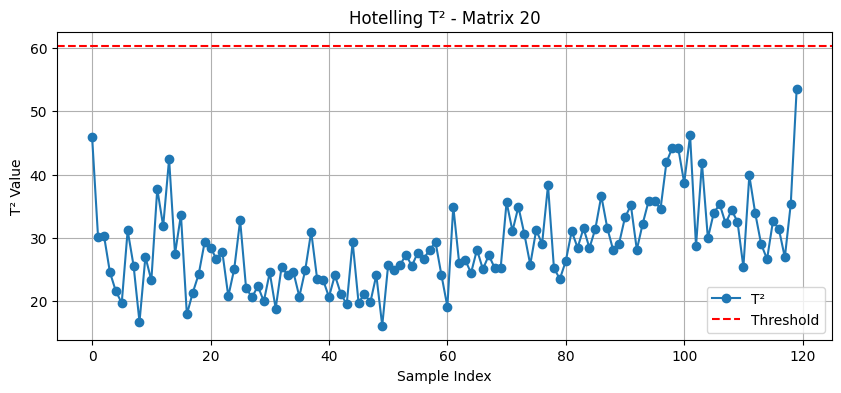

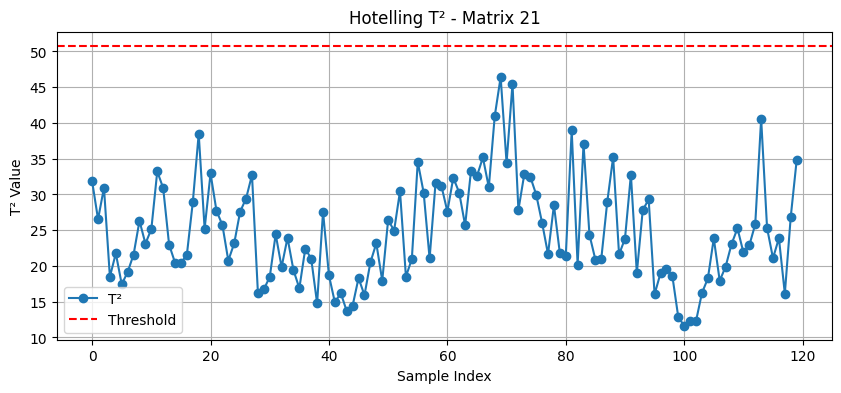

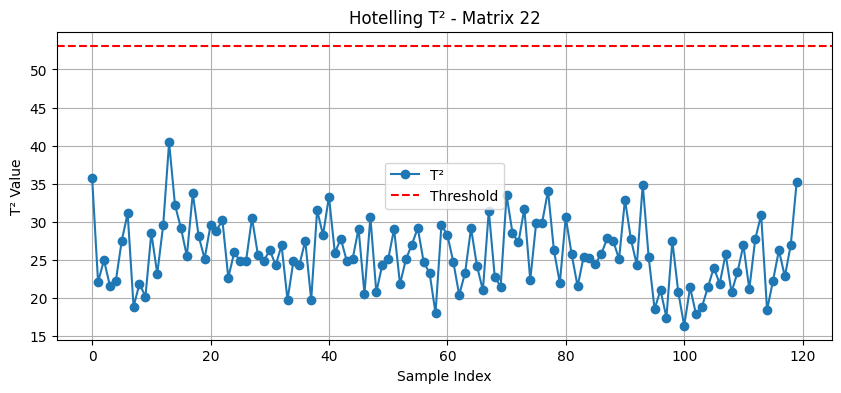

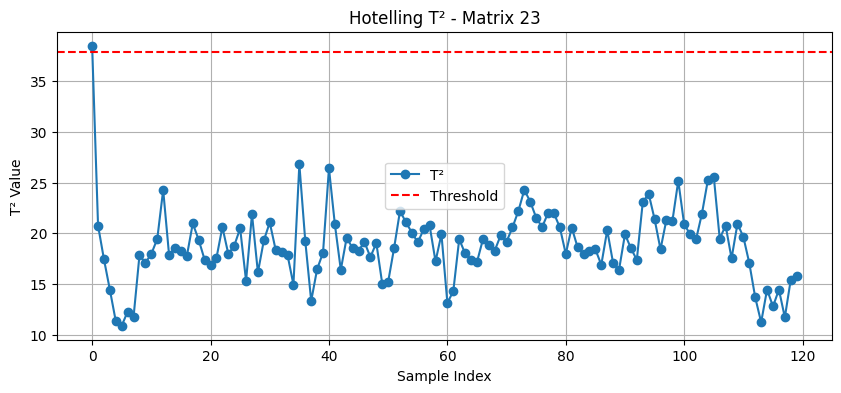

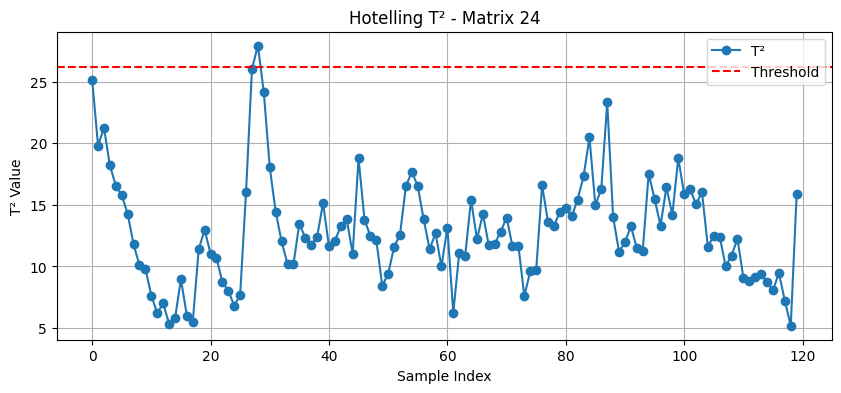

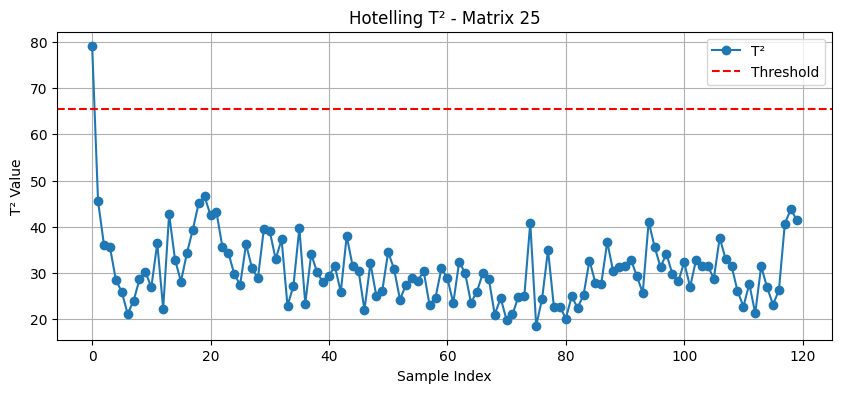

In [13]:
results = analyze_temperature_matrices(list_25l, confidence=0.95, plot=True)

# Access results:
t2_values = results['t2_values']
thresholds = results['thresholds']
anomalies = results['anomalies']

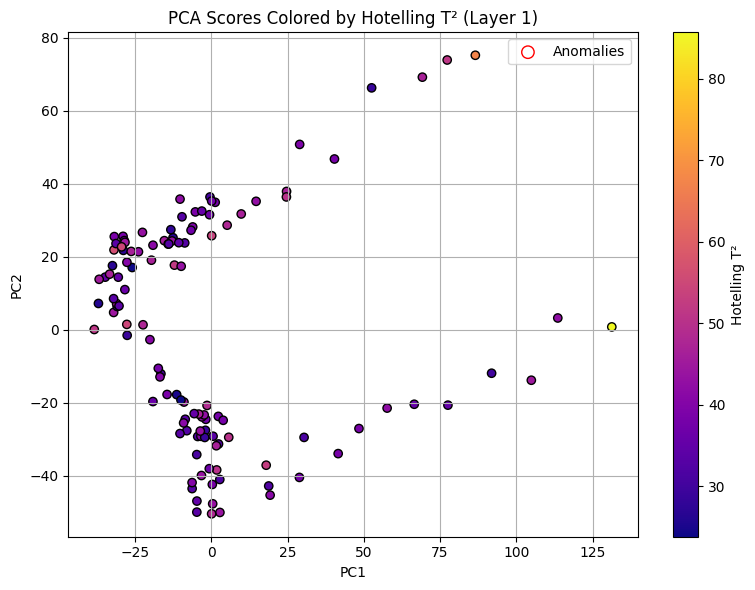

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import f

def plot_pca_hotelling_layer(matrix, confidence=0.95):
    # Step 1: Apply PCA (keep all components for accurate T², but plot first 2)
    pca = PCA(n_components=0.90)
    scores = pca.fit_transform(matrix)
    std_devs = np.sqrt(pca.explained_variance_)
    
    # Step 2: Compute Hotelling T² for each sample
    t2 = np.sum((scores / std_devs) ** 2, axis=1)

    # Step 3: Plot in first 2 PCs
    plt.figure(figsize=(8, 6))
    sc = plt.scatter(scores[:, 0], scores[:, 1], c=t2, cmap='plasma', edgecolor='k')
    plt.colorbar(sc, label="Hotelling T²")
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('PCA Scores Colored by Hotelling T² (Layer 1)')
    plt.grid(True)

    # Step 4: Plot threshold ellipse (optional)
    n, p = matrix.shape[0], scores.shape[1]
    f_crit = f.ppf(confidence, p, n - p)
    t2_thresh = (p * (n - 1) / (n - p)) * f_crit

    # Show samples with T² > threshold
    outliers = np.where(t2 > t2_thresh)[0]
    plt.scatter(scores[outliers, 0], scores[outliers, 1], edgecolors='red', facecolors='none', s=80, label='Anomalies')

    plt.legend()
    plt.tight_layout()
    plt.show()

plot_pca_hotelling_layer(list_25l[0])


#### Hotelling's T² Map Interpretation
This is a statistical map that shows how unusual each pixel's temporal behavior is, based on its intensity over the 5 frames (layers).

Color Map:

* Dark colors (black/dark red): Low Hotelling’s T² → pixel behaves normally.

* Bright yellow/white areas: High T² → pixel’s intensity profile is significantly different from others → possible anomaly.

Localized bright areas may indicate:

* Overheating or poor heat dissipation in that region.

* Anomalous material behavior (e.g., spatter deposits or geometry irregularity).

Uniform T² values imply a stable process in that region.

# References
* [In-Process Monitoring of Selective Laser Melting: Spatial Detection of Defects Via Image Data Analysis](https://re.public.polimi.it/bitstream/11311/1016879/6/in-process%20monitoring%20of%20slm.pdf)

# Further improvements

* cambiare dinamicamente il numero di cluster con l'elbow plot, mi aspetto 2/3 cluster sono ottimi
* non usare la PCA e avere 25 datapoints nel CC
* fare plot di Hotelling T2 come nel paper, magari 3d plot [esempio](https://learnche.org/pid/latent-variable-modelling/principal-component-analysis/hotellings-t2-statistic)